<a href="https://colab.research.google.com/github/indra622/google_speech_command_example/blob/main/GSC_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

아래 코드는 Tensorflow Google Speech Command tutorial의 코드를 사용했습니다.

[원본 코드 링크](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb)



# 1. 필요 라이브러리를 불러오는 과정

In [1]:
import tensorflow as tf
import numpy as np

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

def decode_audio(audio_binary): # -32768 ~ 32767 signed 2-byte 값을 -1.0 ~ 1.0의 float으로 변환
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path): # Directory name을 불러와 label로 지정함
  import os
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] 

def get_waveform_and_label(file_path): # 위 두 가지 method를 통해 data를 1차 가공함
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_spectrogram(waveform): 
  # 16,000 saple (1초) 이하의 입력이 들어온 경우, 나머지 부분을 0으로 채움
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  # short-time fourier transform을 통해 spectrogram을 return
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)   
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def plot_spectrogram(spectrogram, ax): # spectrogram 시각화를 위한 method
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def get_spectrogram_and_label_id(audio, label): # Spectrogram 결과와 label을 통해 data를 2차 가공함
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

def preprocess_dataset(files): # 지정한 files들에 대해 waveform 변환 및 spectrogram을 일괄적으로 수행
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

# 2. dataset load

Mini_speech_commands dataset을 불러오는 과정

데이터 다운로드 후 명령어 리스트, 데이터 크기 등을 출력

In [15]:
import pathlib

data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

commands = np.array(tf.io.gfile.listdir(str(data_dir))) #데이터 디렉토리 이름을 array 형식으로 받음 
commands = commands[commands != 'README.md']
print('명령어 리스트:', commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('전체 발화 개수:', num_samples)
print('명령어당 발화 개수:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))



train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set의 총 발화 수:', len(train_files))
print('Validation set의 총 발화 수:', len(val_files))
print('Test set의 총 발화 수:', len(test_files))

['no' 'right' 'go' 'left' 'up' 'down' 'stop' 'yes' 'README.md']
명령어 리스트: ['no' 'right' 'go' 'left' 'up' 'down' 'stop' 'yes']
전체 발화 개수: 8000
명령어당 발화 개수: 1000
Training set의 총 발화 수: 6400
Validation set의 총 발화 수: 800
Test set의 총 발화 수: 800


# 3. data sample 확인

학습 자료 중, 임의의 데이터 샘플을 추출하여 waveform을 확인

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

9개의 샘플을 선택하여 waveform 확인

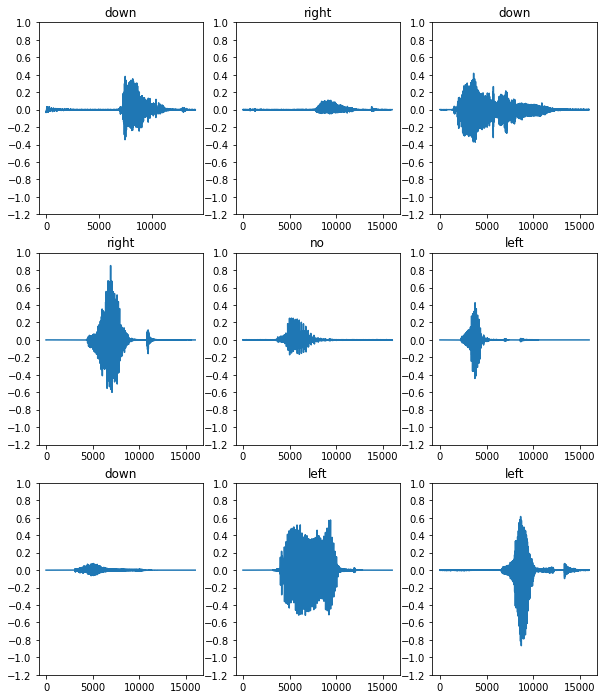

In [4]:
import matplotlib.pyplot as plt # 그래프 시각화를 위한 library

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

샘플에 대한 spectrogram 확인

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


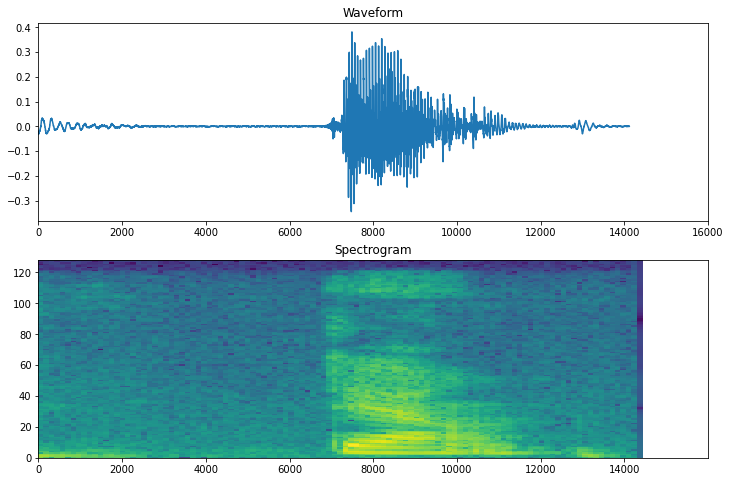

In [5]:
for waveform, label in waveform_ds.take(1): # 가장 앞에 있는 1번 파일을 가져옴 (다른 파일을 원하면 2~8000 사이의 값을 넣음, 반복문이므로 후속 데이터는 시간이 소요될 수 있음)
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

# 4. 모델 학습

dataset 형식으로 데이터를 가공함

CNN 모델 정의 및 학습

In [6]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [7]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x)) # spectrogram(input)과 label(output) 중, input 데이터만 추출하여 사용함

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 17s 140ms/step - loss: 1.7393 - accuracy: 0.3622 - val_loss: 1.2535 - val_accuracy: 0.6313
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.1908 - accuracy: 0.5816 - val_loss: 0.8886 - val_accuracy: 0.7075
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.9243 - accuracy: 0.6770 - val_loss: 0.7375 - val_accuracy: 0.7638
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.7567 - accuracy: 0.7378 - val_loss: 0.6786 - val_accuracy: 0.7887
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6675 - accuracy: 0.7611 - val_loss: 0.5860 - val_accuracy: 0.8050
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5732 - accuracy: 0.7953 - val_loss: 0.5936 - val_accuracy: 0.8125
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5181 - accuracy: 0.8197 - val_loss: 0.5326 - val_accuracy: 0.8175
Epo

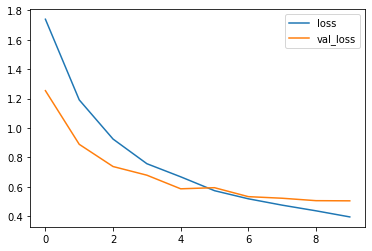

In [9]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# 4. 학습된 모델에 대한 테스트 진행

test set을 이용한 accuracy 측정

In [10]:


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [11]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'전체 test set 에 대한 accuracy: {test_acc:.0%}')

Test set accuracy: 83%


Confusion matrix 확인

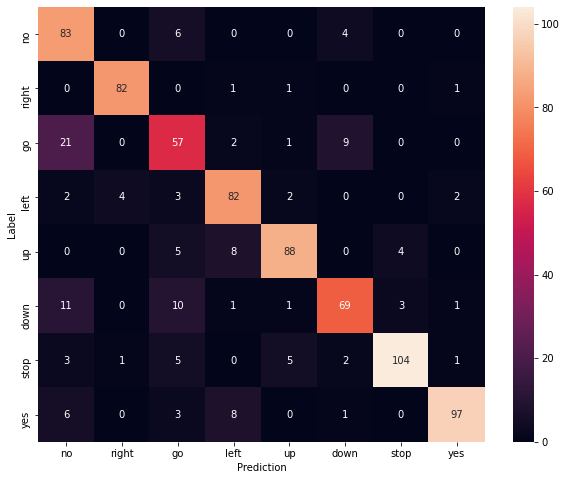

In [12]:
import seaborn as sns # heatmap을 그리기 위한 library

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

임의의 음성에 대한 모델 평가 결과

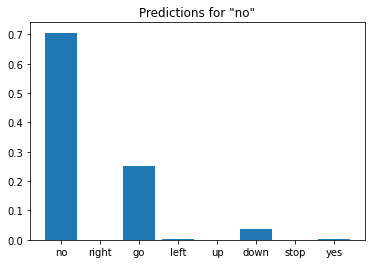

In [13]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()